In [1]:
import pandas
import pyreadr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
transaction = pyreadr.read_r("/data/IDEA_DeFi_Research/Data/Lending_Protocols/Aave/V2/Mainnet/transactions.rds")
df = transaction[None]
df['DateTime'] = df['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
df.head()

,id,type,timestamp,user,userAlias,onBehalfOf,onBehalfOfAlias,pool,reserve,amount,...,priceInUsd,borrowRateModeTo,borrowRateModeFrom,stableBorrowRate,variableBorrowRate,target,totalFee,version,deployment,DateTime
0,0xc70f4c3f447f6a88e9fbb87ac1394b589e469ee57dda...,borrow,1.606841e+09,0xbd723fc4f1d737dcfc48a07fe7336766d34cad5f,Rocky Kuebler,0xbd723fc4f1d737dcfc48a07fe7336766d34cad5f,Rocky Kuebler,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-01 11:46:58
1,0x1ee3db904548c16d2ed3572f3d9894652e031facc8fa...,borrow,1.606902e+09,0x21d05071ca08593e13cd3afd0b4869537e015c92,Odaly Chihuahua-Tovar,0x21d05071ca08593e13cd3afd0b4869537e015c92,Odaly Chihuahua-Tovar,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 04:34:18
2,0x1e8f85330edc5005ead7a7ae8c418fbb64df726d4ffc...,borrow,1.606905e+09,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,LINK,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 05:24:50
3,0x43136c7aba13c072bb19ed88f8eadf859f0bfb994b42...,borrow,1.606913e+09,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,AAVE,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 07:47:21
4,0xd96af0cf05a1e99125fe51ee7e27a1c96cf40ea6e596...,borrow,1.606915e+09,0xdad4c11e8cc6a5c37808d3b31b3b284809f702d1,Jalen Mitchell,0xdad4c11e8cc6a5c37808d3b31b3b284809f702d1,Jalen Mitchell,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 08:10:19


In [3]:
# We are going to make a super basic linear model to try and predict how the AAVE token's price changes each day.
# This script will engineer one feature to use for this predictive task: dailyTransactionCount.

# To do this, we group the data by the date portion of the DateTime object, 
# and then simply count how many transactions are in each group
dailyTransactionCount = df.groupby([df['DateTime'].dt.date]).count()
dailyTransactionCount = dailyTransactionCount[['id']]
dailyTransactionCount.rename(columns={"id": "transactionCount"}, inplace = True)
print(dailyTransactionCount)

            transactionCount
DateTime                    
2020-11-30                 3
2020-12-01                20
2020-12-02               205
2020-12-03              1089
2020-12-04               869
...                      ...
2023-11-26               400
2023-11-27               335
2023-11-28               438
2023-11-29               355
2023-11-30               127

[1091 rows x 1 columns]


In [4]:
# We load the minutely Aave price data here:
aavePrices = pandas.read_csv('/data/IDEA_DeFi_Research/Data/Coin_Prices/Minutely/aavePrices.csv')
# And here, since we want to predict daily prices, we create a new features which is the mean daily price.
aavePrices['DateTime'] = aavePrices['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
dailyMeanPrices = aavePrices.groupby([df['DateTime'].dt.date]).mean()
dailyMeanPrices = dailyMeanPrices[['priceUSD']]
print(dailyMeanPrices)

              priceUSD
DateTime              
2020-11-30  160.040985
2020-12-01  189.916972
2020-12-02  165.751269
2020-12-03  189.176691
2020-12-04  207.015268
...                ...
2023-11-26  119.630025
2023-11-27  116.143040
2023-11-28  118.810638
2023-11-29  125.494667
2023-11-30  113.503231

[1090 rows x 1 columns]


In [5]:
dailyTransactionCount = dailyTransactionCount.merge(dailyMeanPrices, left_index = True, right_index = True)
print(dailyTransactionCount)

            transactionCount    priceUSD
DateTime                                
2020-11-30                 3  160.040985
2020-12-01                20  189.916972
2020-12-02               205  165.751269
2020-12-03              1089  189.176691
2020-12-04               869  207.015268
...                      ...         ...
2023-11-26               400  119.630025
2023-11-27               335  116.143040
2023-11-28               438  118.810638
2023-11-29               355  125.494667
2023-11-30               127  113.503231

[1090 rows x 2 columns]


In [6]:
def data_split1(data_set):
    from sklearn.model_selection import TimeSeriesSplit
    # We want to use the transactionCount to predict the next day's price. To do this, we "lead" the priceUSD
    # column so in a given row, the transaction count is aligned with the next day's price.
    data_set['priceUSD_lead_1'] = data_set['priceUSD'].shift(-1)
    # We need to drop NA values. One NA value is introduced through this "lead" on the last day in the dataset.
    data_set.dropna(inplace=True)
    # In practice, it is better to predict daily percent price changes rather than predicting literal prices, so we compute the daily
    # percent change here by subtraction tomorrow's price from today's and dividing by today's price.
    data_set['dailyPercentChange'] = (data_set['priceUSD_lead_1'] - data_set['priceUSD']) / data_set['priceUSD']
    tss = TimeSeriesSplit(n_splits = 3)
    X = data_set.drop(labels=['priceUSD_lead_1', 'dailyPercentChange'],axis=1)
    y = data_set['dailyPercentChange']
    for train_index, test_index in tss.split(data_set):
        feature_train, feature_test = X.iloc[train_index, :], X.iloc[test_index,:]
        target_train, target_test = y.iloc[train_index], y.iloc[test_index]
    return [feature_train, feature_test, target_train, target_test]

In [7]:
def data_split2(data_set):
    from sklearn.model_selection import TimeSeriesSplit
    # We want to use the transactionCount to predict the next day's price. To do this, we "lead" the priceUSD
    # column so in a given row, the transaction count is aligned with the next day's price.
    dailyTransactionCount['priceUSD_lead_1'] = dailyTransactionCount['priceUSD'].shift(-1)
    # We need to drop NA values. One NA value is introduced through this "lead" on the last day in the dataset.
    dailyTransactionCount.dropna(inplace=True)
    # In practice, it is better to predict daily percent price changes rather than predicting literal prices, so we compute the daily
    # percent change here by subtraction tomorrow's price from today's and dividing by today's price.
    dailyTransactionCount['dailyPercentChange'] = (dailyTransactionCount['priceUSD_lead_1'] - dailyTransactionCount['priceUSD']) / dailyTransactionCount['priceUSD']
    # We want to predict the direction of the daily percent change, so we create a new feature which is the sign of the daily percent change.
    dailyTransactionCount['directionOfDailyChange'] = np.sign(dailyTransactionCount['dailyPercentChange'])
    print(dailyTransactionCount)
    tss = TimeSeriesSplit(n_splits = 3)
    X = dailyTransactionCount.drop(labels=['priceUSD_lead_1', 'dailyPercentChange', 'directionOfDailyChange'],axis=1)
    y = dailyTransactionCount['directionOfDailyChange']
    for train_index, test_index in tss.split(dailyTransactionCount):
        feature_train, feature_test = X.iloc[train_index, :], X.iloc[test_index,:]
        target_train, target_test = y.iloc[train_index], y.iloc[test_index]
    return [feature_train, feature_test, target_train, target_test]

In [8]:
def linear_regression_model(feature_train, feature_test, target_train, target_test):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import classification_report
    # We fit a linear model with the train data, where feature_train is our feature matrix and target_train is our target variable
    # Using LinearRegression to classify the data
    estimator = LinearRegression()
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    # All it is intended to do is get
    # the literal target_test values without the associated datetimes, for plotting purposes.
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # evaluate the linear regression model
    # method1: compare the real result and predict result
    target_predict = estimator.predict(feature_test)
    print("target_predict:\n", target_predict)
    print("compare real result and predict result:\n", target_test == target_predict)
    
    # method2: calculate the accuracy
    accuracy = estimator.score(feature_test, target_test)
    print("accuracy: {0:.2f}%\n".format(accuracy * 100))
    return predictions, target_test_vals

In [9]:
def logistic_regression_model(feature_train, feature_test, target_train, target_test):
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report
    estimator = LogisticRegression(C = 1.0, penalty = "l2", solver = "liblinear", fit_intercept=True, max_iter=1000)
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    # classification report for the logistic regression model
    report = classification_report(target_test, target_predict, labels=[2, 4], target_names=["Up", "Down"], zero_division=1)
    print(report)
    return predictions, target_test_vals

In [10]:
def plot_ground_truth(predictions, target_test_vals):
    # We plot the ground-truth values in blue and the predicted values in red:
    plt.plot(target_test_vals, color = "blue")
    plt.plot(predictions, color = "red")

In [11]:
def plot_difference(predictions, y_test_vals):
    # We plot the difference between our model's predictions and the actual values:
    plt.plot(y_test_vals - predictions)

The linear_regression_model, when applied with data_split1(), yielded suboptimal predictive performance due to the presence of multiple target variables. Consequently, in order to enhance predictive accuracy, a logistic regression model will be employed with a new dataset, data_split2(). This subsequent analysis will primarily concentrate on forecasting the directional movement of prices, specifically focusing on predicting whether the price will increase or decrease in the subsequent trading day.

In [12]:
# linear regression model
'''
train_set[0] = feature_train
train_set[1] = feature_test
train_set[2] = target_train
train_set[3] = target_test
'''
train_set = list()
train_set = data_split1(dailyTransactionCount) # store all 4 types of data inside
# using the linear_regression_model to make prediction
predictions, target_test_vals = linear_regression_model(train_set[0], train_set[1], train_set[2], train_set[3])

target_predict:
 [ 8.72058358e-03  7.28611191e-03  1.01338012e-02  5.40608082e-03
  4.82163746e-03  1.56448998e-03  5.67712872e-03  3.87239254e-03
  3.79632215e-03  3.15400184e-03  4.40678067e-03  5.46440706e-03
  1.63377160e-02  2.05462467e-02  3.61399229e-02  1.97393714e-02
  1.80458303e-02  1.39256675e-02  1.27469648e-02  1.00063947e-02
  1.15841839e-02  1.41331677e-02  1.34673681e-02  1.06635602e-02
  1.56201956e-02  1.16783536e-02  7.47300558e-03  1.33503787e-02
  1.61998750e-02  1.65621091e-02  1.15888238e-02  5.65512728e-03
  1.10818932e-02  1.05952698e-02  4.52888954e-03  6.30767955e-03
  9.48402083e-03  3.93664261e-03  9.72590988e-03  5.26678398e-03
  4.43654036e-03  1.43208119e-02  1.42756597e-02  1.92807946e-02
  9.27084145e-03  1.00394193e-02  9.41332161e-03  1.20906074e-02
  8.80163015e-03  7.05899564e-03  8.87891447e-03  5.06095451e-03
  1.36455549e-03  3.05810362e-03  3.42614967e-03  8.92408695e-03
  2.06843679e-03  4.32230480e-04  4.18193099e-03  1.76043132e-03
  1.7288

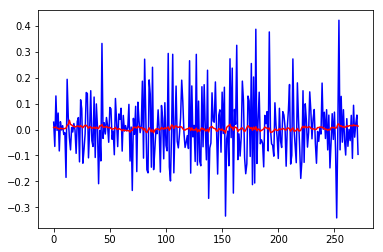

In [13]:
plot_ground_truth(predictions, target_test_vals)

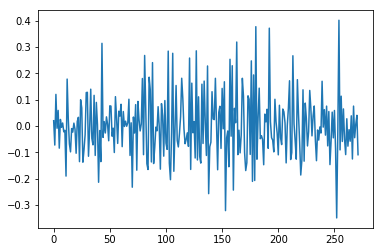

In [14]:
plot_difference(predictions, target_test_vals)

In [15]:
# logistic regression model
'''
train_set[0] = feature_train
train_set[1] = feature_test
train_set[2] = target_train
train_set[3] = target_test
'''
train_set = list()
train_set = data_split2(dailyTransactionCount) # store all 4 types of data inside
# using the linear_regression_model to make prediction
predictions, target_test_vals = logistic_regression_model(train_set[0], train_set[1], train_set[2], train_set[3])

            transactionCount    priceUSD  priceUSD_lead_1  dailyPercentChange  \
DateTime                                                                        
2020-11-30                 3  160.040985       189.916972            0.186677   
2020-12-01                20  189.916972       165.751269           -0.127244   
2020-12-02               205  165.751269       189.176691            0.141329   
2020-12-03              1089  189.176691       207.015268            0.094296   
2020-12-04               869  207.015268       198.888097           -0.039259   
...                      ...         ...              ...                 ...   
2023-11-24               296  123.024718       109.346837           -0.111180   
2023-11-25               464  109.346837       119.630025            0.094042   
2023-11-26               400  119.630025       116.143040           -0.029148   
2023-11-27               335  116.143040       118.810638            0.022968   
2023-11-28               438

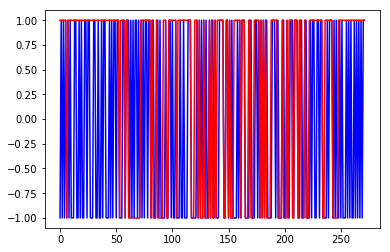

In [16]:
plot_ground_truth(predictions, target_test_vals)

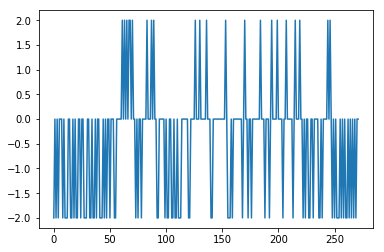

In [17]:
plot_difference(predictions, target_test_vals)